# TICL Trackster Smoothing

This notebook builds a labeled dataset for identifying complete and incomplete tracksters.

In [1]:
import uproot
from plotting_utils import plot_event
from matching_utils import split_on_shared_energy, get_eid_splits, unfold_tracksters, get_highest_energy_fraction_simtracksters

%matplotlib inline

# double gamma (two photons)
file_name = "data/ntuples_13801550_969.root"

tracksters_ds    = {file_name: "ticlNtuplizer/tracksters"}
simtracksters_ds = {file_name: "ticlNtuplizer/simtrackstersSC"}
associations_ds  = {file_name: "ticlNtuplizer/associations"}

tracksters = uproot.open(tracksters_ds)
simtracksters = uproot.open(simtracksters_ds)
associations = uproot.open(associations_ds)

### Association scores
- 1 means completely unmatched
- 0 means a perfect 

The idea is to use argmax over the scores and then get the index of the best matched trackster

In [2]:
eid = 1

r2si = associations["tsCLUE3D_recoToSim_SC"].array()[eid]
r2s = associations["tsCLUE3D_recoToSim_SC_score"].array()[eid] # [tracksters] -> [simtracksters]

s2ri = associations["tsCLUE3D_simToReco_SC"].array()[eid]
s2r = associations["tsCLUE3D_simToReco_SC_score"].array()[eid] # [simtracksters] -> [tracksters]

print("Reco to sim:", r2s)
print("Reco to sim indexes:", r2si)

print("Sim to reco:", s2r)
print("Sim to reco indexes:", s2ri)

Reco to sim: [[0.594, 0.124], [0.983, 0.000295], [0.985, 0.000688]]
Reco to sim indexes: [[1, 0], [0, 1], [1, 0]]
Sim to reco: [[0.00518, 1, 1], [0.00868, 0.998, 1]]
Sim to reco indexes: [[2, 0, 1], [1, 2, 0]]


In [3]:
perfect_eids, split_eids = get_eid_splits(tracksters, simtracksters, associations)
complete_tracksters, incomplete_tracksters = split_on_shared_energy(tracksters, simtracksters, associations, split_eids)

Total reco tracksters: 140, complete: 77, Incomplete: 58


### Inspect the results

Event 1: complete: [1, 2] incomplete : [0]


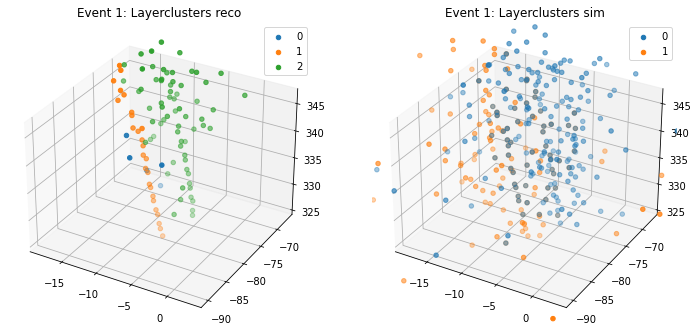

In [4]:
for i, (eid, it) in enumerate(incomplete_tracksters[:1]):
    print(f"Event {eid}: complete: {complete_tracksters[i][1]} incomplete : {it}")
    plot_event(tracksters, simtracksters, eid)

In [5]:
import numpy as np

In [6]:
r2si

<Array [[1, 0], [0, 1], [1, 0]] type='3 * var * int64'>

In [7]:
str(r2s)

'[[0.594, 0.124], [0.983, 0.000295], [0.985, 0.000688]]'

In [38]:
# find the correct trackster to merge with

pairs = []

for eid, idxs in incomplete_tracksters:
    r2si = associations["tsCLUE3D_recoToSim_SC"].array()[eid]
    r2s = associations["tsCLUE3D_recoToSim_SC_score"].array()[eid]
    for idx in idxs:
        match = np.argmin(r2s[idx])
        sidx = r2si[idx][match]
        # id of simtrackster it should merge with
        reco_fr, reco_st = get_highest_energy_fraction_simtracksters(tracksters, simtracksters, associations, eid)

        matches = np.where(np.array(reco_st) == sidx)[0]
        candidates = sorted(matches, key=lambda x: reco_fr[x], reverse=True)
        candidate = candidates[0]

        unmatches = np.where(np.array(reco_st) != sidx)[0]
        for unmatch in unmatches:
            pairs.append((eid, idx, unmatch, 0))

        if candidate == idx:
            raise RuntimeError("Can't merge with itself")

        pairs.append((eid, idx, candidate, 1))

In [39]:
pairs

[(1, 0, 1, 0),
 (1, 0, 2, 1),
 (3, 2, 0, 0),
 (3, 2, 1, 1),
 (4, 4, 0, 0),
 (4, 4, 1, 0),
 (4, 4, 3, 0),
 (4, 4, 2, 1),
 (4, 3, 2, 0),
 (4, 3, 4, 0),
 (4, 3, 0, 1),
 (4, 1, 2, 0),
 (4, 1, 4, 0),
 (4, 1, 0, 1),
 (6, 0, 2, 0),
 (6, 0, 1, 1),
 (7, 2, 1, 0),
 (7, 2, 0, 1),
 (8, 3, 0, 1),
 (8, 2, 0, 1),
 (8, 4, 0, 1),
 (10, 2, 0, 0),
 (10, 2, 1, 1),
 (11, 2, 1, 0),
 (11, 2, 0, 1),
 (12, 2, 1, 0),
 (12, 2, 3, 0),
 (12, 2, 0, 1),
 (12, 3, 0, 0),
 (12, 3, 2, 0),
 (12, 3, 1, 1),
 (15, 1, 2, 0),
 (15, 1, 0, 1),
 (16, 2, 0, 0),
 (16, 2, 1, 1),
 (18, 2, 1, 0),
 (18, 2, 0, 1),
 (18, 3, 1, 0),
 (18, 3, 0, 1),
 (23, 2, 0, 0),
 (23, 2, 1, 1),
 (25, 2, 1, 0),
 (25, 2, 0, 1),
 (30, 1, 2, 0),
 (30, 1, 0, 1),
 (31, 1, 1, 0),
 (31, 1, 2, 0),
 (31, 1, 3, 0),
 (31, 1, 0, 1),
 (31, 2, 1, 0),
 (31, 2, 2, 0),
 (31, 2, 3, 0),
 (31, 2, 0, 1),
 (34, 4, 0, 0),
 (34, 4, 5, 0),
 (34, 4, 1, 1),
 (34, 3, 0, 0),
 (34, 3, 5, 0),
 (34, 3, 1, 1),
 (34, 2, 0, 0),
 (34, 2, 5, 0),
 (34, 2, 1, 1),
 (34, 5, 1, 0),
 (34, 5, 2, 0

### Create the dataset

In [32]:
vertices_x = []
vertices_y = []
vertices_z = []
vertices_energy = []
vertices_indexes = []
trackster_label = []
trackster_event = []
# trackster_file = []

def get_event_data(eid):
    vx = tracksters["vertices_x"].array()[eid]
    vy = tracksters["vertices_y"].array()[eid]
    vz = tracksters["vertices_z"].array()[eid]
    ve = tracksters["vertices_energy"].array()[eid]
    vi = tracksters["vertices_indexes"].array()[eid]
    return vx, vy, vz, ve, vi

datafiles = [
    f"new_ntuples_13872546_{x}.root" for x in range(100, 110)
]

for datafile in datafiles:
    print("Processing file:", datafile)
    filepath = f"ntuples/{datafile}"
    try:
        tracksters = uproot.open({filepath: "ticlNtuplizer/tracksters"})
        simtracksters = uproot.open({filepath: "ticlNtuplizer/simtrackstersSC"})
        associations = uproot.open({filepath: "ticlNtuplizer/associations"})
    except:
        print("file not found:", datafile)
        continue

    # categorize events into perfect and split
    perfect_eids, split_eids = get_eid_splits(tracksters, simtracksters, associations)

    # get the perfect tracksters
    perfect_tracksters = unfold_tracksters(tracksters, perfect_eids)

    # get the complete and incomplete tracksters from split events
    complete_tracksters, incomplete_tracksters = split_on_shared_energy(
        tracksters,
        simtracksters,
        associations,
        split_eids
    )

    # assign labels to trackster sets
    set_labels = (
        (incomplete_tracksters, 0),
        (complete_tracksters, 1),
        (perfect_tracksters, 1),
    )

    for tset, label in set_labels:
        for eid, tids in tset:
            vx, vy, vz, ve, vi = get_event_data(eid)
            for tid in tids:
                vertices_x.append(vx[tid])
                vertices_y.append(vy[tid])
                vertices_z.append(vz[tid])
                vertices_energy.append(ve[tid])
                vertices_indexes.append(vi[tid])
                trackster_label.append(label)
                trackster_event.append(eid)
                # trackster_file.append(datafile)

Processing file: new_ntuples_13872546_100.root
Total reco tracksters: 169, complete: 85, Incomplete: 71
Processing file: new_ntuples_13872546_101.root
Total reco tracksters: 165, complete: 84, Incomplete: 71
Processing file: new_ntuples_13872546_102.root
Total reco tracksters: 173, complete: 97, Incomplete: 71
Processing file: new_ntuples_13872546_103.root
Total reco tracksters: 162, complete: 80, Incomplete: 70
Processing file: new_ntuples_13872546_104.root
Total reco tracksters: 185, complete: 96, Incomplete: 83
Processing file: new_ntuples_13872546_105.root
Total reco tracksters: 145, complete: 73, Incomplete: 65
Processing file: new_ntuples_13872546_106.root
Total reco tracksters: 185, complete: 96, Incomplete: 81
Processing file: new_ntuples_13872546_107.root
Total reco tracksters: 182, complete: 106, Incomplete: 72
Processing file: new_ntuples_13872546_108.root
Total reco tracksters: 179, complete: 94, Incomplete: 77
Processing file: new_ntuples_13872546_109.root
Total reco track

In [33]:
ds = uproot.recreate("./tracksters_ds_10e.root")
ds["tracksters"] = {
    "vertices_x": vertices_x,
    "vertices_y": vertices_y,
    "vertices_z": vertices_z,
    "vertices_energy": vertices_energy,
    "vertices_indexes": vertices_indexes,
    "trackster_label": trackster_label,
    "trackster_event": trackster_event,
}
#   "trackster_file": trackster_file,
ds.close()